# Q. 91 - 100

91. K-meansによる減色処理 (Step.1) 色の距離によるクラス分類
92. K-meansによる減色処理 (Step.2) 減色処理
93. 機械学習の学習データの用意 (Step.1) IoUの計算
94. 機械学習の学習データの用意 (Step.2) ランダムクラッピング
95. ニューラルネットワーク (Step.1) ディープラーニングにする
96. ニューラルネットワーク (Step.2) 学習
97. 簡単な物体検出 (Step.1) スライディングウィンドウ + HOG
98. 簡単な物体検出 (Step.2) スライディングウィンドウ + NN
99. 簡単な物体検出 (Step.3) NonMaximumSuppression
100. 簡単な物体検出 (Step.4) 評価 Precision, Recall, F-score, mAP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io

img_orig = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256.png')
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_128 = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_128x128.png')
img_gray_128 = cv2.cvtColor(img_128, cv2.COLOR_RGB2GRAY)
img_noise = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_noise.png')
img_dark = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_dark.png')
img_dark_gray = cv2.cvtColor(img_dark, cv2.COLOR_RGB2GRAY)
img_light = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_light.png')
img_light_gray = cv2.cvtColor(img_light, cv2.COLOR_RGB2GRAY)

img_thorino = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/thorino.jpg')
img_thorino_gray = cv2.cvtColor(img_thorino, cv2.COLOR_RGB2GRAY)

img_eye = io.imread("https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_eye.png")
img_eye = cv2.cvtColor(img_eye, cv2.COLOR_RGBA2RGB)

img_seg = io.imread("https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/seg_sample.png")
img_connect = io.imread("https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/connect_sample.png")
img_gazo = io.imread("https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/gazo_sample.png")

img_madara = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/madara_256x256.png')

# Q.91. K-meansによる減色処理 (Step.1) 色の距離によるクラス分類

imori_256x256.png をK-meansを用いた減色処理せよ。

減色処理はQ.6でも扱ったが、Q.6では予め決めた色に減色した。ここで扱うのはK-meansを用いて動的に減色する色を決定する。

アルゴリズムは,

1. 画像からランダムにK個のRGB成分をサンプリングする。（これをクラスと呼ぶことにする。）
2. 画像のそれぞれの画素に対して色の距離が最小となるクラスのインデックスを割り振る。
3. 色の距離 dis = sqrt( (R-R')^2 + (G-G')^2 + (B-B')^2)
4. 各インデックスに対応する色成分の平均をRGBそれぞれに対して取り、新たなクラスとする。
5. 元のクラスと新しいクラスが全く同じならK-meansを終了する。そうでなければ、新しいクラスを元クラスとして2-3を繰り返す。
6. 元画像の各画素で色の距離が最小となるクラスのRGBを割り当てる。

ここでは1-2を実装せよ。

クラス数はk=5とする

- 1においてはnp.random.seed(0)として、np.random.choice(np.arrange(画像のWxH), 5, replace=False)
- 解答では画像を np.reshape(img, (h * w, -1)) する

まずは3-5のループを考えずに実装せよ

random selected color
[[ 63 103 164]
 [207 187 215]
 [152 114 135]
 [ 97  91  95]
 [ 89  73  84]]


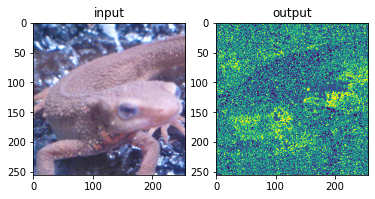

In [2]:
def color_kmeans_step1(img, class_n=5):
    #  get shape
    h, w, c = img.shape
    _img = np.reshape(img, (h * w, -1))

    np.random.seed(0)
    
    # select one index randomly
    i = np.random.choice(np.arange(h * w), class_n, replace=False)
    colors = _img[i].copy()

    print("random selected color")
    print(colors)

    # assign near color
    clss = np.zeros((h * w), dtype=int)

    for i in range(h * w):
        dis = np.sqrt(np.sum((colors - _img[i]) ** 2, axis=1))
        clss[i] = np.argmin(dis)

    out = clss.reshape(h, w)
    out = out.astype(np.uint8)
    return out

out = color_kmeans_step1(img_orig)

fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].set_title("input")
ax[0].imshow(img_orig)
ax[1].set_title("output")
ax[1].imshow(out)
plt.show()

# Q.92. K-meansによる減色処理 (Step.2) 減色処理

ここではアルゴリズム3-5も実装せよ。

[[207.6526996  197.53595997 222.97581822]
 [107.56407112 127.6284488  181.10070509]
 [175.6351195  147.72709434 170.43954717]
 [ 59.411048    60.8453116   93.65135424]
 [105.54069901  92.67320074 121.85312716]]


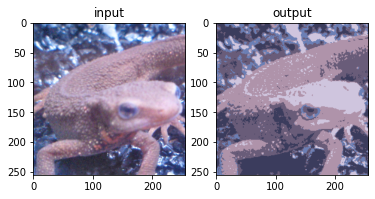

In [3]:
def color_kmeans(img, class_n=5):
    h, w, c = img.shape
    _img = np.reshape(img, (h * w, -1))

    np.random.seed(0)

    # get index randomly
    i = np.random.choice(np.arange(h * w), class_n, replace=False)
    colors = _img[i].copy()

    while True:
        # prepare pixel class label
        clss = np.zeros((h * w), dtype=int)
        
        # each pixel
        for i in range(h * w):
            # get distance from index pixel
            dis = np.sqrt(np.sum((colors - _img[i])**2, axis=1))
            # get argmin distance
            clss[i] = np.argmin(dis)

        # selected pixel values
        colors_tmp = np.zeros((class_n, 3))
        
        # each class label
        for i in range(class_n):
            colors_tmp[i] = np.mean(_img[clss == i], axis=0)

        # if not any change
        if (colors == colors_tmp).all():
            break
        else:
            colors = colors_tmp.copy()

    # prepare out image
    out = np.zeros((h * w, 3), dtype=np.float32)

    # assign selected pixel values  
    for i in range(class_n):
        out[clss == i] = colors[i]

    print(colors)
        
    out = np.clip(out, 0, 255)
    out = np.reshape(out, (h, w, 3))
    out = out.astype(np.uint8)
    return out

out = color_kmeans(img_orig)

fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].set_title("input")
ax[0].imshow(img_orig)
ax[1].set_title("output")
ax[1].imshow(out)
plt.show()

[[ 87.52758282 107.36587591  76.54035654]
 [ 25.22445696  25.18543846  23.89018504]
 [ 56.26674799  65.17429094  51.96035377]
 [150.77214528 167.30990332 116.24784426]
 [225.76426713 230.33165655 225.31352992]]


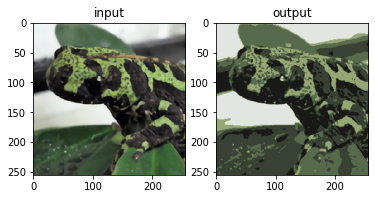

In [4]:
out = color_kmeans(img_madara)

fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].set_title("input")
ax[0].imshow(img_madara)
ax[1].set_title("output")
ax[1].imshow(out)
plt.show()

# Q.93. 機械学習の学習データの用意 (Step.1) IoUの計算

ここから機械学習で用いる学習データの準備を行う。

最終的にはイモリの顔か否かを判別する識別器を作りたい。そのためにはイモリの顔の画像とイモリの顔以外の画像が必要になる。それらを用意するためのプログラムを作成する。

そのためにはイモリの顔周辺を一枚の画像から切り抜く必要がある。 そこで一つの矩形を設定して(GT: Ground-truth, 正解と呼ぶ)、ランダムに切り抜いた矩形がGTとある程度重なっていれば、イモリの顔となる。

その重なり具合を計算するのが、IoU: Intersection over unionであり、次式で計算される。

```bash
R1...Ground-truthの領域 , R2...切り抜いた矩形 , Rol...R1とR2の重なっている領域
IoU = |Rol| / |R1 + R2 - Rol|
```

ここでは、以下の２つの矩形のIoUを計算せよ。

[x1, y1, x2, y2] x1,y1...矩形の左上のx,y  x2,y2...矩形の右下のx,y

```python
a = np.array((50, 50, 150, 150), dtype=np.float32)
b = np.array((60, 60, 170, 160), dtype=np.float32)
```

In [5]:
def get_iou(a, b):
    area_a = (a[2] - a[0]) * (a[3] - a[1]) # get area of a
    area_b = (b[2] - b[0]) * (b[3] - b[1]) # get area of b

    iou_x1 = np.maximum(a[0], b[0]) # get left top x of IoU
    iou_y1 = np.maximum(a[1], b[1]) # get left top y of IoU
    iou_x2 = np.minimum(a[2], b[2]) # get right bottom of IoU
    iou_y2 = np.minimum(a[3], b[3]) # get right bottom of IoU

    area_iou = np.maximum(iou_x2 - iou_x1, 0) * np.maximum(iou_y2 - iou_y1, 0) # get area of IoU
    iou = area_iou / (area_a + area_b - area_iou) # get overlap ratio between IoU and all area
    return iou

# [x1, y1, x2, y2]
a = np.array((50, 50, 150, 150), dtype=np.float32)
b = np.array((60, 60, 170, 160), dtype=np.float32)

print(get_iou(a, b))

0.627906976744186


# Q.94. 機械学習の学習データの用意 (Step.2) ランダムクラッピング

次に、imori_256x256.png からランダムに画像を切り抜いて(cropping, クラッピングと呼ぶ)学習データを作成する。

ここでは画像から60x60のサイズの矩形をランダムに200個切り抜け。

ただし、以下の条件を満たせ。

np.random.seed(0)として、切り抜く矩形の左上のx1 = np.random.randint(W-60), y1=np.random.randint(H-60)で求めよ。

GT (gt = np.array((130, 120, 190, 180), dtype=np.float32))とのIoUが0.5以上の時はその矩形に教師ラベル1, 0.5未満の場合はラベル0を与えよ。

答えは、ラベル1の矩形を赤、ラベル0の矩形を青、GTを緑にしている。 これでイモリの顔の画像、それ以外の画像を簡易的に用意できた。

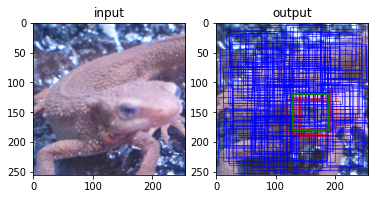

In [6]:
# crop and create database
def crop_bbox(img, gt, crop_n=200, crop_size=60, th=0.5):
    # get shape
    h, w, c = img.shape
    
    crops = []
    labels = []

    # each crop
    for i in range(crop_n):
        # get left top x of crop bounding box
        x1 = np.random.randint(w - crop_size)
        # get left top y of crop bounding box
        y1 = np.random.randint(h - crop_size)
        # get right bottom x of crop bounding box
        x2 = x1 + crop_size
        # get right bottom y of crop bounding box
        y2 = y1 + crop_size

        # crop bounding box
        crop = np.array((x1, y1, x2, y2))

        # get IoU between crop box and gt
        _iou = get_iou(gt, crop)
        
        crops.append(crop)

        # assign label
        if _iou >= th:
            labels.append(1)
        else:
            labels.append(0)
            
    return np.array(crops), np.array(labels)

# gt bounding box
gt = np.array((130, 120, 190, 180), dtype=np.float32)

crops, labels = crop_bbox(img_orig, gt)

fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].set_title("input")
ax[0].imshow(img_orig)
ax[1].set_title("output")
ax[1].imshow(img_orig)

for i in range(len(crops)):
    c = "red" if labels[i] == 1 else "blue"
    x1, y1, x2, y2 = crops[i]
    ax[1].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=c, linewidth=0.5))

ax[1].add_patch(plt.Rectangle((gt[0], gt[1]), gt[2] - gt[0], gt[3] - gt[1], fill=False, edgecolor="green", linewidth=2))
    
plt.show()

# Q.95. ニューラルネットワーク (Step.1) 使ってみる
ここでは識別器としてニューラルネットワークを用いる。 これは現在流行っているディープラーニングである。

入力層、中間層(ユニット数:64)、出力層(1)のネットワークは次のようにできる。

これは、排他的論理和を実現するネットワークである。

これの中間層をもう１つ増やして、学習とテストを行え。


```python
np.random.seed(46)

class NeuralNet:
    def __init__(self, in_dim=2, layer1_dim=64, out_dim=1, lr=0.2):
        self.layer1_w = np.random.normal(0, 1, [in_dim, layer1_dim])
        self.layer1_b = np.random.normal(0, 1, [layer1_dim])
        self.out_w = np.random.normal(0, 1, [layer1_dim, out_dim])
        self.out_b = np.random.normal(0, 1, [out_dim])
        self.lr = lr

    def forward(self, x):
        self.outputs = []
        self.outputs.append(x)
        x = sigmoid(np.dot(x, self.layer1_w) + self.layer1_b)
        self.outputs.append(x)
        x = sigmoid(np.dot(x, self.out_w) + self.out_b)
        self.outputs.append(x)
        return x

    def train(self, x, t):
        # backpropagation output layer
        En = (self.outputs[-1] - t) * self.outputs[-1] * (1 - self.outputs[-1])
        grad_En = En
        grad_wout = np.dot(self.outputs[-2].T, En)
        grad_bout = np.dot(np.ones([En.shape[0]]), En)
        self.out_w -= self.lr * grad_wout
        self.out_b -= self.lr * grad_bout

        # backpropagation layer1
        grad_layer1_u = np.dot(En, self.out_w.T) * self.outputs[-2] * (1 - self.outputs[-2])
        grad_layer1_w = np.dot(self.outputs[-3].T, grad_layer1_u)
        grad_layer1_b = np.dot(np.ones([grad_layer1_u.shape[0]]), grad_layer1_u)
        self.layer1_w -= self.lr * grad_layer1_w
        self.layer1_b -= self.lr * grad_layer1_b

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

train_x = np.array([[0,0], [0,1], [1,0], [1,1]], dtype=np.float32)
train_t = np.array([[0], [1], [1], [0]], dtype=np.float32)

nn = NeuralNet()

# train
for i in range(1000):
    nn.forward(train_x)
    nn.train(train_x, train_t)

# test
for j in range(4):
    x = train_x[j]
    t = train_t[j]
    print("in:", x, "pred:", nn.forward(x))
```


In [7]:
np.random.seed(46)

class NeuralNet:
    def __init__(self, in_dim=2, layer1_dim=64, layer2_dim=64, out_dim=1, lr=0.2):
        self.layer1_w = np.random.normal(0, 1, [in_dim, layer1_dim])
        self.layer1_b = np.random.normal(0, 1, [layer1_dim])
        self.layer2_w = np.random.normal(0, 1, [layer1_dim, layer2_dim])
        self.layer2_b = np.random.normal(0, 1, [layer2_dim])
        self.out_w = np.random.normal(0, 1, [layer2_dim, out_dim])
        self.out_b = np.random.normal(0, 1, [out_dim])
        self.lr = lr

    def forward(self, x):
        self.outputs = []
        self.outputs.append(x)
        x = sigmoid(np.dot(x, self.layer1_w) + self.layer1_b)
        self.outputs.append(x)
        x = sigmoid(np.dot(x, self.layer2_w) + self.layer2_b)
        self.outputs.append(x)
        x = sigmoid(np.dot(x, self.out_w) + self.out_b)
        self.outputs.append(x)
        return x

    def train(self, x, t):
        # backpropagation output layer
        En = (self.outputs[-1] - t) * self.outputs[-1] * (1 - self.outputs[-1])
        grad_En = En
        grad_wout = np.dot(self.outputs[-2].T, En)
        grad_bout = np.dot(np.ones([En.shape[0]]), En)
        self.out_w -= self.lr * grad_wout
        self.out_b -= self.lr * grad_bout
        
        # backpropagation layer2
        grad_layer2_u = np.dot(En, self.out_w.T) * self.outputs[-2] * (1 - self.outputs[-2])
        grad_layer2_w = np.dot(self.outputs[-3].T, grad_layer2_u)
        grad_layer2_b = np.dot(np.ones([grad_layer2_u.shape[0]]), grad_layer2_u)
        self.layer2_w -= self.lr * grad_layer2_w
        self.layer2_b -= self.lr * grad_layer2_b

        # backpropagation layer1
        grad_layer1_u = np.dot(grad_layer2_u, self.layer2_w.T) * self.outputs[-3] * (1 - self.outputs[-3])
        grad_layer1_w = np.dot(self.outputs[-4].T, grad_layer1_u)
        grad_layer1_b = np.dot(np.ones([grad_layer1_u.shape[0]]), grad_layer1_u)
        self.layer1_w -= self.lr * grad_layer1_w
        self.layer1_b -= self.lr * grad_layer1_b

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

train_x = np.array([[0,0], [0,1], [1,0], [1,1]], dtype=np.float32)
train_t = np.array([[0], [1], [1], [0]], dtype=np.float32)

nn = NeuralNet()

# train
for i in range(1000):
    nn.forward(train_x)
    nn.train(train_x, train_t)

# test
for j in range(4):
    x = train_x[j]
    t = train_t[j]
    print("in:", x, "pred:", nn.forward(x))

in: [0. 0.] pred: [0.03334014]
in: [0. 1.] pred: [0.96289547]
in: [1. 0.] pred: [0.95748493]
in: [1. 1.] pred: [0.04397555]


# Q.96. ニューラルネットワーク (Step.2) 学習

ここでは、Q.94で用意した学習データ200のHOG特徴量を入力として、Q.95で作成したニューラルネットを学習せよ。

ここでは、学習データに対してAccuracyを計算せよ。ただし、出力(予測確率)が0.5以上で予測ラベルが1、0.5未満で予測ラベルは0としてAccuracyを計算せよ。 学習のハイパーパラメータは、下記の通り。

- 学習率 lr= 0.01
- 学習回数 epch=10000
- 切り抜いた画像を60x60にリサイズして、HOG特徴量を取得せよ。(HOGは8x8を1セルとする。)

ここでは、学習データをそのまま評価に使用する。

In [8]:
# get HOG
def hog(img):
    # Grayscale
    def rgb2gray(img):
        return img[..., 0] * 0.2126 + img[..., 1] * 0.7152 + img[..., 2] * 0.0722

    # Magnitude and gradient
    def get_gradxy(gray):
        H, W = gray.shape

        # padding before grad
        gray = np.pad(gray, (1, 1), 'edge')

        # get grad x
        gx = gray[1:H+1, 2:] - gray[1:H+1, :W]
        # get grad y
        gy = gray[2:, 1:W+1] - gray[:H, 1:W+1]
        # replace 0 with 
        gx[gx == 0] = 1e-6

        return gx, gy

    # get magnitude and gradient
    def get_maggrad(gx, gy):
        # get gradient maginitude
        magnitude = np.sqrt(gx ** 2 + gy ** 2)

        # get gradient angle
        gradient = np.arctan(gy / gx)

        gradient[gradient < 0] = np.pi / 2 + gradient[gradient < 0] + np.pi / 2

        return magnitude, gradient

    # Gradient histogram
    def quantization(gradient):
        # prepare quantization table
        gradient_quantized = np.zeros_like(gradient, dtype=int)

        # quantization base
        d = np.pi / 9

        # quantization
        for i in range(9):
            gradient_quantized[np.where((gradient >= d * i) & (gradient <= d * (i + 1)))] = i

        return gradient_quantized


    # get gradient histogram
    def gradient_histogram(gradient_quantized, magnitude, n=8):
        # get shape
        h, w = magnitude.shape

        # get cell num
        cell_n_h = h // n
        cell_n_w = w // n
        histogram = np.zeros((cell_n_h, cell_n_w, 9), dtype=np.float32)

        # each pixel
        for y in range(cell_n_h):
            for x in range(cell_n_w):
                for j in range(n):
                    for i in range(n):
                        histogram[y, x, gradient_quantized[y * n + j, x * n + i]] += magnitude[y * n + j, x * n + i]

        return histogram

    # histogram normalization
    def normalization(histogram, c=3, epsilon=1):
        cell_n_h, cell_n_w, hist_c = histogram.shape
        ## each histogram
        for y in range(cell_n_h):
            for x in range(cell_n_w):
                for c in range(hist_c):
                    histogram[y, x, c] /= np.sqrt(np.sum(histogram[max(y - 1, 0) : min(y + 2, cell_n_h),  max(x - 1, 0) : min(x + 2, cell_n_w), c] ** 2) + epsilon)

        return histogram

    gray = rgb2gray(img)
    gx, gy = get_gradxy(gray)
    magnitude, gradient = get_maggrad(gx, gy)
    gradient_quantized = quantization(gradient)
    histogram = gradient_histogram(gradient_quantized, magnitude)
    histogram = normalization(histogram)
    return histogram


# resize using bi-linear
def resize(img, h, w):
    _h, _w, _c  = img.shape

    ah = 1. * h / _h
    aw = 1. * w / _w

    y = np.arange(h).repeat(w).reshape(w, -1)
    x = np.tile(np.arange(w), (h, 1))

    # get coordinate toward x and y of resized image
    y = (y / ah)
    x = (x / aw)

    # transfer to int
    ix = np.floor(x).astype(np.int32)
    iy = np.floor(y).astype(np.int32)

    # clip index
    ix = np.minimum(ix, _w-2)
    iy = np.minimum(iy, _h-2)

    # get distance between original image index and resized image index
    dx = x - ix
    dy = y - iy

    dx = np.tile(dx, [_c, 1, 1]).transpose(1, 2, 0)
    dy = np.tile(dy, [_c, 1, 1]).transpose(1, 2, 0)
    
    out = (1 - dx) * (1 - dy) * img[iy, ix] + dx * (1 - dy) * img[iy, ix + 1] + (1 - dx) * dy * img[iy + 1, ix] + dx * dy * img[iy + 1, ix + 1]
    out[out > 255] = 255

    return out


# crop bounding box and make dataset
def make_dataset(img, gt, crop_n=200, crop_size=60, th=0.5, size=32):
    h, w, _ = img.shape

    # get HOG feature dimension
    hog_feat_n = ((size // 8) ** 2) * 9

    db = np.zeros([crop_n, hog_feat_n + 1])

    # each crop
    for i in range(crop_n):
        x1 = np.random.randint(w - crop_size)
        y1 = np.random.randint(h - crop_size)
        x2 = x1 + crop_size
        y2 = y1 + crop_size

        crop = np.array([x1, y1, x2, y2])
        crop_area = img[y1:y2, x1:x2]
        crop_area = resize(crop_area, size, size)

        _hog = hog(crop_area)
        db[i, :hog_feat_n] = _hog.ravel()
        db[i, -1] = 1 if get_iou(gt, crop) >= th else 0 # label

    return db


# prepare gt bounding box
gt = np.array((130, 120, 190, 180), dtype=np.float32)

# get database
db = make_dataset(img_orig, gt)

# train neural network
# get input feature dimension
input_dim = db.shape[1] - 1
train_x = db[:, :input_dim]
train_t = db[:, -1][..., None]

nn = NeuralNet(in_dim=input_dim, lr=0.01)

# training
for i in range(10_000):
    nn.forward(train_x)
    nn.train(train_x, train_t)

# test
accuracy_n = 0.

for x, t in zip(train_x, train_t):
    prob = nn.forward(x)

    # count accuracy
    pred = 1 if prob >= 0.5 else 0
    if t == pred:
        accuracy_n += 1

accuracy = accuracy_n / len(db)
print("Accuracy >> {} ({} / {})".format(accuracy, accuracy_n, len(db)))

Accuracy >> 1.0 (200.0 / 200)


# Q.97. 簡単な物体検出 (Step.1) スライディングウィンドウ + HOG

ここから物体検出を行う。

物体検出とは、画像中でどこに何が写っているかを出力するタスクである。 例えば、画像の[x1, y1, x2, y2]の位置に犬がいるなど。 このような物体を囲む矩形のことをBounding-box(バウンディングボックス)と呼ぶ。

ここでは簡単な物体検出のアルゴリズムを作成する。

1. 画像の左上からスライディングウィンドウを行う。
2. 各画像の位置について、注目位置を中心に複数の矩形を用意する。
3. それぞれの矩形に対応する画像を切り抜いて、特徴抽出(HOG, SIFTなど)を行う。
4. 識別機(CNN, SVMなど)に掛けて各矩形が物体か否かを判別する。

これである程度の物体と矩形の座標が得られる。現在は物体検出はディープラーニングによる手法(Faster R-CNN, YOLO, SSDなど)が主流であるが、ディープラーニングが流行る前まではこのようなスライディングウィンドウの手法が主流であった。今回は検出の基礎を学ぶため、スライディングウィンドウを扱う。

ここでは1-3を実装する。

imori_256x255.png に対してイモリの目の検出を行う。 条件は以下。

矩形は下記の3つを用いる。

```python
recs = np.array(((42, 42), (56, 56), (70, 70)), dtype=np.float32)
```

スライドは4ピクセルおきに行う。(1ピクセルでもいいが、計算が多くなって処理が長くなってしまう。)
矩形が画像サイズをはみ出る場合は、はみ出ないように変形する。
矩形部分を切り抜いたら、その部分を32x32にリサイズする。
HOG特徴量の取得は8x8を1セルとする。

In [9]:
def sliding_window_step1(img, size=32):
    h, w, _ = img.shape
    
    # base rectangle [h, w]
    recs = np.array(((42, 42), (56, 56), (70, 70)), dtype=np.float32)

    # sliding window
    for y in range(0, h, 4):
        for x in range(0, w, 4):
            for rec in recs:
                # get half size of ractangle
                dh = int(rec[0] // 2)
                dw = int(rec[1] // 2)

                x1 = max(x - dw, 0) # get left top x
                x2 = min(x + dw, w) # get left top y
                y1 = max(y - dh, 0) # get right bottom x
                y2 = min(y + dh, h) # get right bottom y

                # crop region
                region = img[max(y - dh, 0) : min(y + dh, h), max(x - dw, 0) : min(x + dw, w)]

                # resize crop region
                region = resize(region, size, size)

                # get HOG feature
                region_hog = hog(region).ravel()

# Q.98. 簡単な物体検出 (Step.2) スライディングウィンドウ + NN

imori_256x256.png に対して、ここではQ.97で求めた各矩形のHOG特徴量を入力として、Q.96で学習したニューラルネットでイモリの顔か否かを識別せよ。

ここでスコア(予測確率)が0.7以上の矩形を描画せよ。

<ipython-input-10-04cf3216e080>:35: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array(detects, dtype=np.float32)


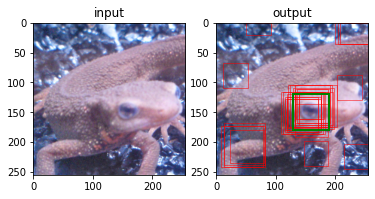

In [10]:
def sliding_window_classify(img, size=32, prob_th=0.8):
    h, w, _ = img.shape
    
    # base rectangle [h, w]
    recs = np.array(((42, 42), (56, 56), (70, 70)), dtype=np.float32)
    
    detects = []
    
    # sliding window
    for y in range(0, h, 4):
        for x in range(0, w, 4):
            for rec in recs:
                # get half size of ractangle
                dh = int(rec[0] // 2)
                dw = int(rec[1] // 2)

                x1 = max(x - dw, 0) # get left top x                
                x2 = min(x + dw, w) # get left top y
                y1 = max(y - dh, 0) # get right bottom x
                y2 = min(y + dh, h) # get right bottom y

                # crop region
                region = img[max(y - dh, 0) : min(y + dh, h), max(x - dw, 0) : min(x + dw, w)]
                region = resize(region, size, size)

                # get HOG feature
                region_hog = hog(region).ravel()
                
                # predict score using neural network
                score = nn.forward(region_hog)

                if score >= prob_th:
                    detects.append([x1, y1, x2, y2, score])

    return np.array(detects, dtype=np.float32)

detects = sliding_window_classify(img_orig)

fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].set_title("input")
ax[0].imshow(img_orig)
ax[1].set_title("output")
ax[1].imshow(img_orig)

for i in range(len(detects)):
    x1, y1, x2, y2, score = detects[i]
    ax[1].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="red", linewidth=0.5))

ax[1].add_patch(plt.Rectangle((gt[0], gt[1]), gt[2] - gt[0], gt[3] - gt[1], fill=False, edgecolor="green", linewidth=2))
    
plt.show()

# Q.99. 簡単な物体検出 (Step.3) Non-Maximum Suppression

Q.97であらかたの検出はできたが、このままではBrounding-boxの数が多すぎて、ここから何かしらの処理に繋げるには不便である。 そこで、NMS: Non-maximum suppressionという手法を用いて矩形の数を減らす。

NMSとはスコアの高いBounding-boxのみを残す手法であり、アルゴリズムは以下の通り。

1. Boundinb-boxの集合Bをスコアが高い順にソートする。
2. スコアが最大のものをb0とする。
3. b0と他のBounding-boxのIoUを計算する。IoUが閾値t以上のBounding-boxをBから削除する。B0は出力する集合Rに加え、Bから削除する。
4. 2-3をBがなくなるまで行う。
5. Rを出力する。

Q.98にNMS(閾値t=0.25)を組み込み、出力を描画せよ。 解答では検出の左上にスコアも加えている。

精度はともあれ、これで検出の一連の流れが完了した。 ニューラルネットの学習を増やしたりすることで、検出の精度は更に向上ができる。

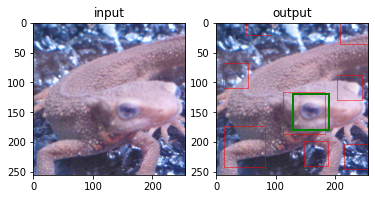

In [11]:
def nms(bboxes, iou_th=0.5):
    _bboxes = bboxes.copy()
    res_inds = np.arange(len(_bboxes))
    selected_inds = []
    
    while len(res_inds) > 0:
        i = res_inds[np.argmax(_bboxes[res_inds, -1])]
        selected_inds.append(i)
        res_inds = np.array([x for x in res_inds if x != i], dtype=int)

        base_bb = _bboxes[i]
        res_bb = _bboxes[res_inds]
        
        _x1, _y1, _x2, _y2 = base_bb[:4]
        _s = np.maximum(_x2 - _x1 , 0) * np.maximum(_y2 - _y1, 0)

        res_s = np.maximum(res_bb[:, 2] - res_bb[:, 0], 0) * np.maximum(res_bb[:, 3] - res_bb[:, 1], 0)

        iou_x1 = np.maximum(_x1, res_bb[:, 0])
        iou_y1 = np.maximum(_y1, res_bb[:, 1])
        iou_x2 = np.minimum(_x2, res_bb[:, 2])
        iou_y2 = np.minimum(_y2, res_bb[:, 3])
        iou_s = np.maximum(iou_x2 - iou_x1, 0) * np.maximum(iou_y2 - iou_y1, 0)

        iou_ratio = iou_s / (res_s + _s - iou_s)
        
        delete_inds = res_inds[iou_ratio >= iou_th]
        res_inds = np.array([x for x in res_inds if x not in delete_inds])

    return selected_inds

selected_inds = nms(detects, iou_th=0.25)
_detects = detects[selected_inds]

fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].set_title("input")
ax[0].imshow(img_orig)
ax[1].set_title("output")
ax[1].imshow(img_orig)

for d in _detects:
    x1, y1, x2, y2, score = d
    ax[1].add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="red", linewidth=0.5))

ax[1].add_patch(plt.Rectangle((gt[0], gt[1]), gt[2] - gt[0], gt[3] - gt[1], fill=False, edgecolor="green", linewidth=2))
    
plt.show()

# Q.100. 簡単な物体検出 (Step.4) 評価 Precision, Recall, F-score, mAP

ついに100問目！！！

ここでは検出の評価指標を実装する。

検出はBounding-boxとそのクラスの２つが一致していないと、精度の評価ができない。 検出の評価指標には、Recall, Precision, F-score, mAPなどが存在する。

Recall ... 正解の矩形がどれだけ検出できたか。正解をどれだけ網羅できたかを示す。[0,1]の範囲を取り、1が最高。

- Recall = G' / G
- G' ... Ground-truthの中で検出のどれかとIoUが閾値t以上となったGround-truthの数。
- G ... Ground-truthの矩形の数。

Precision ... 検出がどれだけ正確に行われたかを示す。[0,1]の範囲を取り、1が最高。

- Precision = D' / D
- D' ... 検出の中で、Ground-truthのどれかとIoUが閾値t以上となった検出の数。
- D ... 検出の数。

F-score ... RecallとPrecisonの調和平均。　２つのバランスを示すもので、[0,1]の範囲を取り、1が最高。

- F-score = 2 * Recall * Precision / (Recall + Precision)

文字を検出する文字検出はRecall, Precision, F-scoreで精度を測ることが多い。

mAP ... Mean Average Precision。物体を検出する物体検出では、mAPで測ることが多い。mAPの計算方法は少し複雑である。

各検出に関してGround-truthとのIoUが閾値t以上かどうかを判断して、表を作成する。

```bash
Detect | judge
------------------
detect1 |   1   (1はGround-truthとのIoU>=tとなったもの)
detect2 |   0   (0はGround-truthとのIoU<tとなったもの)
detect3 |   1
```

mAP = 0として、上から順に見て、judgeが1の時は、見ているものの上すべてに関して、Precisionを計算し、mAPに加算する。
上から順に2を行い、全て行ったら、加算回数でmAPを割る。
以上でmAPが求まる。上の例でいうと、

- detect1 が1なので、Precisionを求める。Precision = 1/1 = 1なので、mAP = 1
- detect2 が0なので、無視。
- detect3 が1なので、Precisionを求める。Precision = 2/3 = 0.67 なので、 mAP = 1 + 0.67 = 1.67
- mAPに加算したのは計2回なので、mAP = 1.67 / 2 = 0.835 となる。

ここでは、閾値t=0.5として、Recall, Precision, F-score, mAPを算出せよ。 Ground-truthは次とする。


In [12]:
# [x1, y1, x2, y2]
gt = np.array([[130, 120, 190, 180], ], dtype=np.float32)

# Recall, Precision, F-score
iou_th = 0.5

Rs = np.zeros((len(gt)))
Ps = np.zeros((len(_detects)))

for i, g in enumerate(gt):
    iou_x1 = np.maximum(g[0], _detects[:, 0])
    iou_y1 = np.maximum(g[1], _detects[:, 1])
    iou_x2 = np.minimum(g[2], _detects[:, 2])
    iou_y2 = np.minimum(g[3], _detects[:, 3])
    iou_s = np.maximum(0, iou_x2 - iou_x1) * np.maximum(0, iou_y2 - iou_y1)
    g_s = (g[2] - g[0]) * (g[3] - g[1])
    d_s = (_detects[:, 2] - _detects[:, 0]) * (_detects[:, 3] - _detects[:, 1])
    ious = iou_s / (g_s + d_s - iou_s)
    
    Rs[i] = 1 if np.sum(ious >= iou_th) > 0 else 0
    Ps[ious >= iou_th] = 1
    

R = np.mean(Rs)
P = np.mean(Ps)
F = (2 * P * R) / (P + R) 

print("Recall >> {:.2f} ({} / {})".format(R, np.sum(Rs), len(Rs)))
print("Precision >> {:.2f} ({} / {})".format(P, np.sum(Ps), len(Ps)))
print("F-score >> ", F)

# mAP
mAP = np.mean([np.sum(Ps[:i+1]) / (i + 1) for i in range(len(_detects)) if Ps[i] == 1])
print("mAP >>", mAP)

Recall >> 1.00 (1.0 / 1)
Precision >> 0.12 (1.0 / 8)
F-score >>  0.2222222222222222
mAP >> 1.0
